In [ ]:
!pip install -q diffusers accelerate transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.5 MB/s eta 0:00:00


See if we have got access to a GPU (very important!).

In [ ]:
!nvidia-smi

Tue May 16 15:17:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

And that's it for the setup part! We're now ready to start generating images 🎇

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

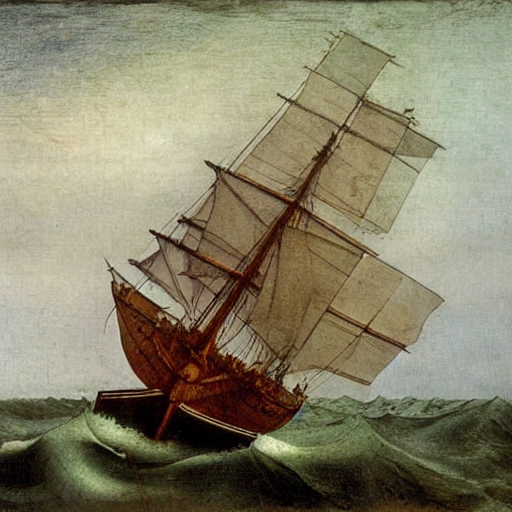

In [ ]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")
prompt = "sailing ship in storm by Leonardo da Vinci" #@param {type:"string"}
images = pipeline(prompt=prompt).images

images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

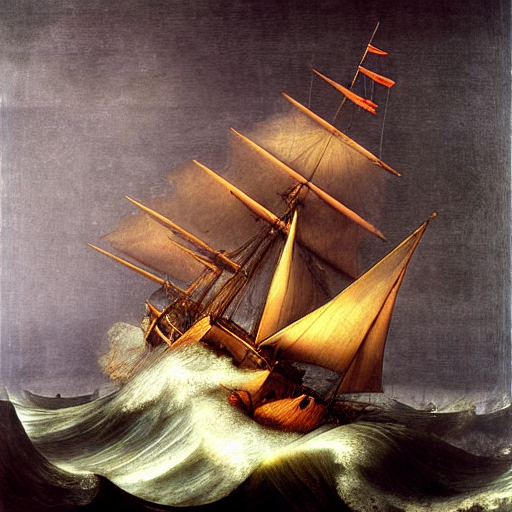

In [ ]:
import torch

seed = 1552 #@param {type:"integer"}
images = pipeline(prompt=prompt, generator=torch.manual_seed(seed)).images

images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

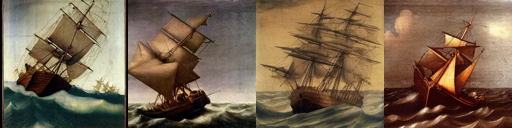

In [ ]:
import PIL

def make_grid(images, rows, cols, resize_to=128):
    images = [image.resize((resize_to, resize_to)) for image in images]
    w, h = images[0].size
    grid = PIL.Image.new("RGB", size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

num_images_per_prompt = 4 #@param {type:"integer"}
images = pipeline(prompt=prompt, num_images_per_prompt=num_images_per_prompt).images
make_grid(images, 1, 4)

In [ ]:
import time

def benchmark(pipeline, prompt="a dog"):
    # call the `pipeline` object here on the `prompt` to
    # warm up the hardware.
    _ = pipeline(prompt=prompt)

    # run for five iterations.
    tic = time.time_ns()
    for _ in range(5):
        # call the `pipeline` object here on the `prompt`.
        _ = pipeline(prompt=prompt)
    tok = time.time_ns()
    # print the total elapsed time.
    print(f"Execution time -- {(tok - tic) / 1e6:.1f} ms\n")

We delete the previous `pipeline` and initialize two new pipelines:

1. FP32 mode
2. FP16 mode

In [ ]:
del pipeline
fp32_pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")
fp16_pipeline = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 # specify the float16 data-type from `torch`
).to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Now, let's take them on benchmarking ⏰

In [ ]:
print("*** FP32 Pipeline ***")
benchmark(fp32_pipeline)

print("\n*** FP16 Pipeline ***")
benchmark(fp16_pipeline)

*** FP32 Pipeline ***


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Execution time -- 19621.1 ms


*** FP16 Pipeline ***


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Execution time -- 11423.4 ms



The speedup is clear ⚡️

The speedup is more prominent when there are more images to generate. The numbers will also vary depending on the GPU we're using.

Going forward in this notebook, we'll default to FP16 computations to save us some memory and speed.

> 💡 **Note**: Diffusers supports many forms of optimizations that can help you run the pipelines as optimally as possible with little to no code changes. These optimizations include attention slicing, CPU offloading, use of flash attention, etc. We encourage you to explore these options [here](https://huggingface.co/docs/diffusers/main/en/optimization/opt_overview).  

  0%|          | 0/50 [00:00<?, ?it/s]

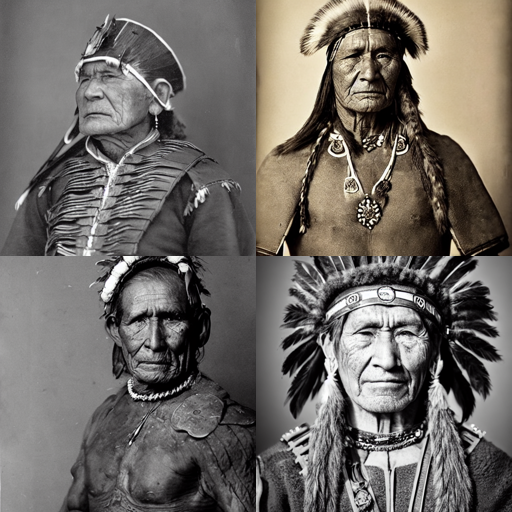

In [ ]:
prompt = "portrait photo of a old warrior chief"
images = fp16_pipeline(prompt=prompt, num_images_per_prompt=4).images
make_grid(images, rows=2, cols=2, resize_to=256)

In [ ]:
#@markdown Enter some keywords that you want to be reflected in the generated images. Don't forget to add a leading whitespace. An example: `"50mm portrait photography, hard rim lighting photography--beta"`.
promt_improvement = ", tribal panther make up, blue on red, side profile, looking away, serious eyes" #@param {type:"string"}
prompt += promt_improvement

  0%|          | 0/50 [00:00<?, ?it/s]

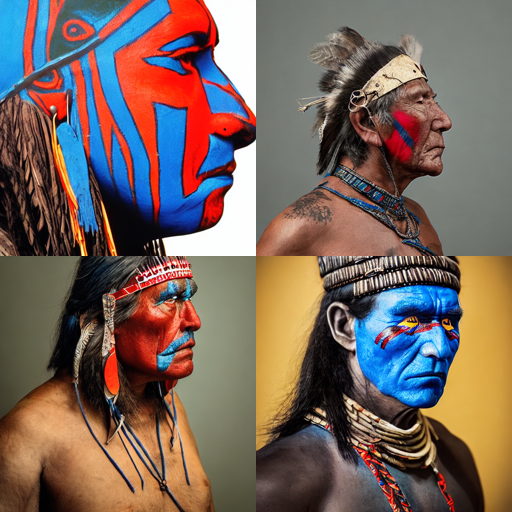

In [ ]:
images = fp16_pipeline(prompt=prompt, num_images_per_prompt=4).images
make_grid(images, rows=2, cols=2, resize_to=256)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


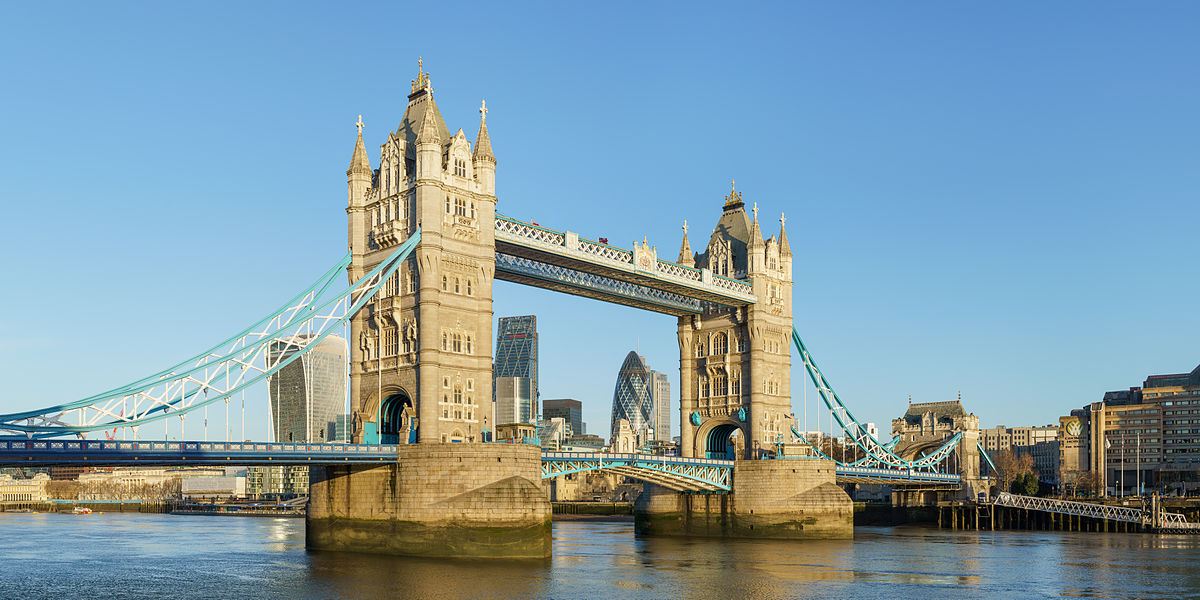

In [ ]:
from diffusers import StableDiffusionInstructPix2PixPipeline
from diffusers.utils import load_image

model_id = "timbrooks/instruct-pix2pix"
pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
).to("cuda")
original_image = load_image("https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Tower_Bridge_from_Shad_Thames.jpg/1200px-Tower_Bridge_from_Shad_Thames.jpg")
original_image

  0%|          | 0/100 [00:00<?, ?it/s]

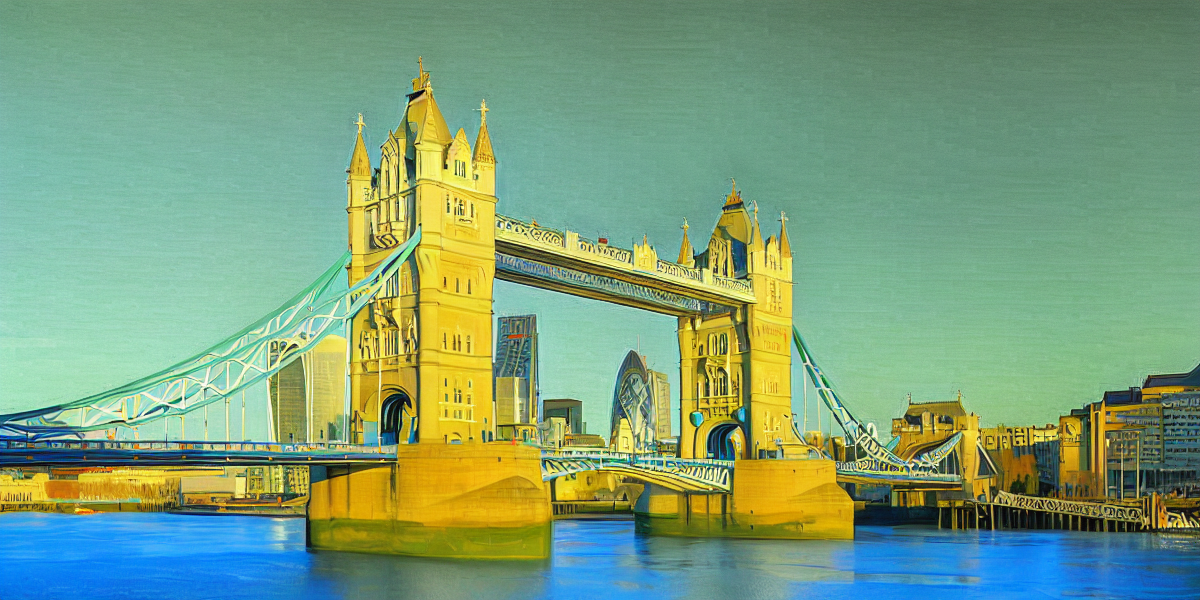

In [ ]:
#@markdown Enter an "edit instruction" that corresponds to the changes you want to see in the edited image. Example: "turn the image to have a nightly feel."
edit_instruction = "Make it a picasso painting" #@param {type:"string"}
edited_image = pipeline(edit_instruction, image=original_image).images[0]
edited_image

In [ ]:
# The larger the lists the more the runtime.
# Feel free to edit these lists.
# Sensible value range for:
# `img_cfg_scales`: [1., 2.]
# `text_cfg_scales`: [6., 15.]
# Don't make the lists to have more than lengths of 3 for this session.

img_cfg_scales = [1., 1.5, 2.]
text_cfg_scales = [7., 10., 12.]
edited_images = []

for img_cfg in img_cfg_scales:
    for text_cfg in text_cfg_scales:
        image = pipeline(
            edit_instruction,
            image=original_image,
            image_guidance_scale=img_cfg,
            guidance_scale=text_cfg,
            num_inference_steps=20,
        ).images[0]
        edited_images.append(image)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Let's now plot these edited images to see the impact of different `image_guidance_scale` (denoted as $s_i$) and `guidance_scale` (denoted as $s_t$) values.

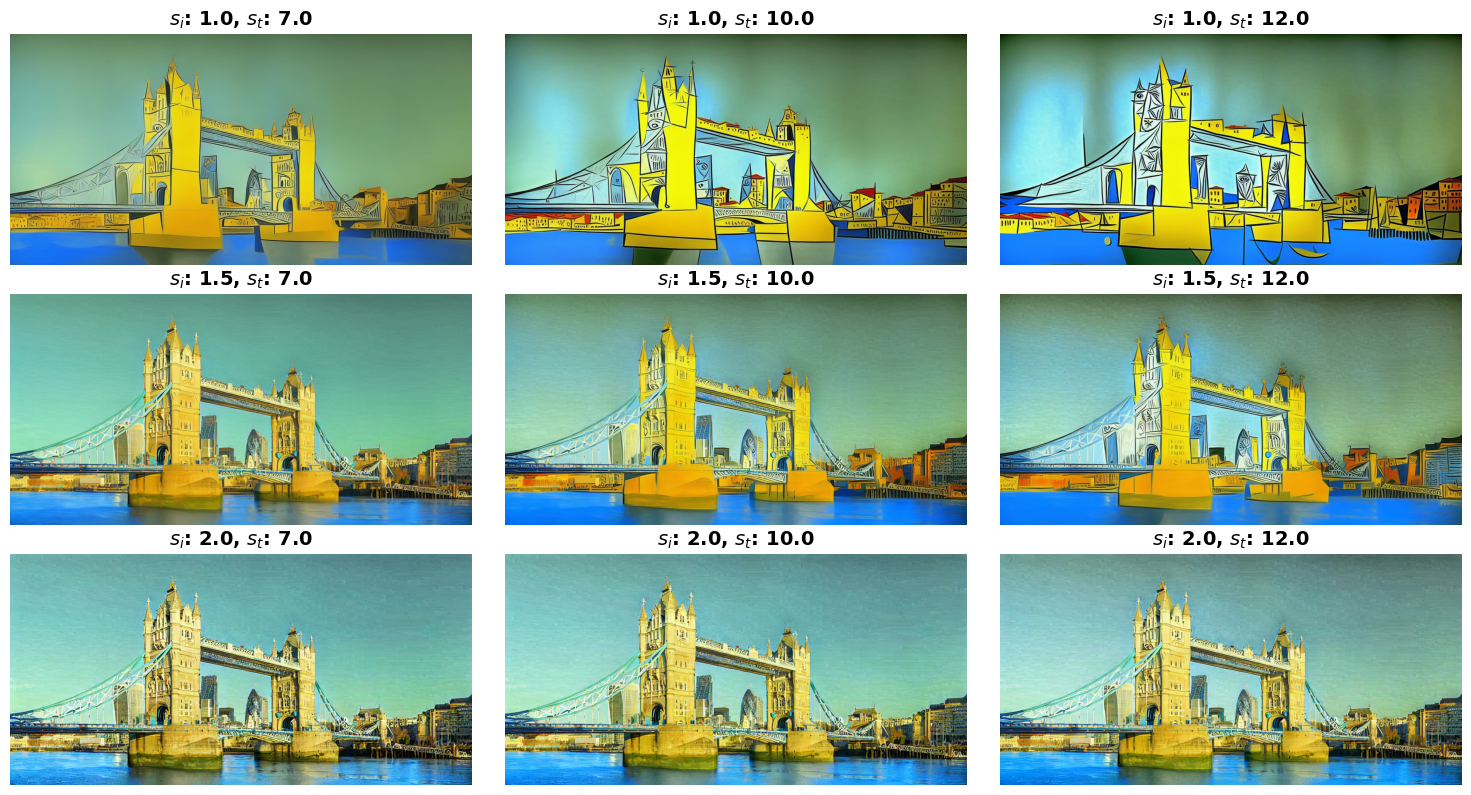

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(15, 8))
for i, image in enumerate(edited_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(image))
    plt.title(
        f"$s_i$: {img_cfg_scales[i // 3]}, $s_t$: {text_cfg_scales[i % 3]}",
        fontsize=14,
        fontweight="bold",
    )
    plt.axis("off")
plt.tight_layout()

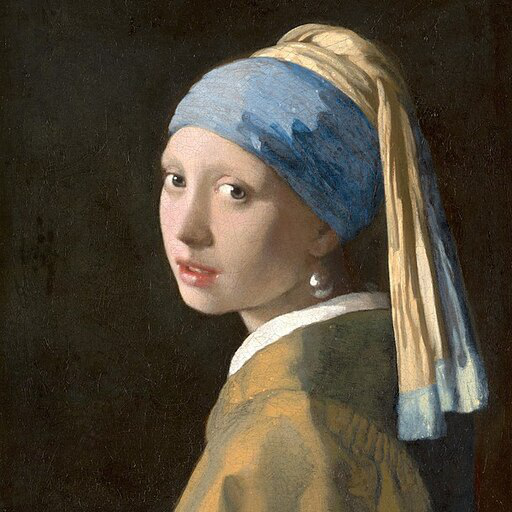

In [ ]:
from diffusers.utils import load_image

# Let's load the popular vermeer image
image_url = "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png" #@param {type:"string"}
image = load_image(image_url)
image

Extract the canny edge map from the image:

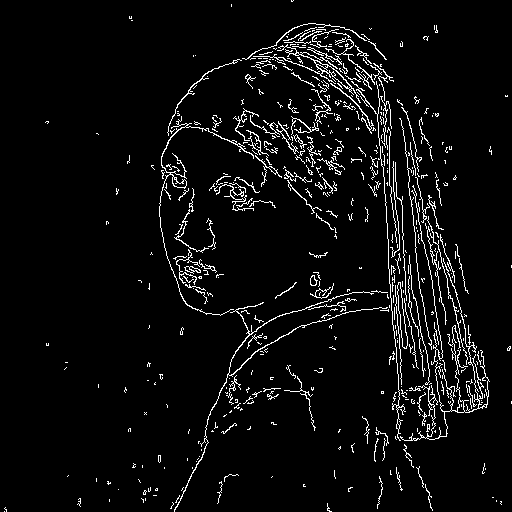

In [ ]:
import cv2
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = PIL.Image.fromarray(image)
canny_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16 # pass the float16 datatype from torch
).to("cuda") # make sure `controlnet` is moved to GPU.
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    "sd-dreambooth-library/mr-potato-head",
    controlnet=controlnet,
    torch_dtype=torch.float16  # pass the float16 datatype from torch
).to("cuda") # make sure `controlnet` is moved to GPU.

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


And then generate:

  0%|          | 0/50 [00:00<?, ?it/s]

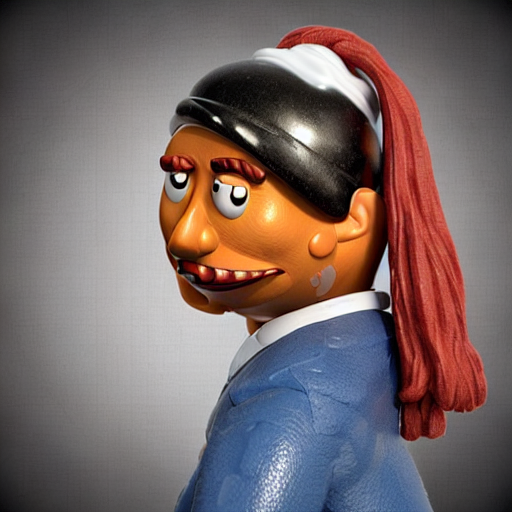

In [ ]:
prompt = "a photo of sks mr potato head, best quality, extremely detailed"
output = pipeline(prompt, canny_image)
output.images[0]

In [ ]:
prompt = "a photo of the face of a woman"
pipeline = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to() # make sure `controlnet` is moved to GPU.

# We're fixing the seed to have a more deterministic way of
# comparing the outputs here. Any diffusion pipeline in Diffusers
# comes with a `generator` argument in its __call__ method to
# help fix the seed.
pipeline(prompt=prompt, generator=torch.manual_seed(0)).images[0]

Now leverage the `SemanticStableDiffusionPipeline` to semantically control the output image by specifying what attributes we want to control.

In [ ]:
#@markdown `edit_prompt_one` denotes one of the semantic attributes that we want to control in the generated images. So, for example, if we wanted to make the woman wear glasses, we could write: `"glasses, wearing glasses"`. Here "glasses" is an object we want added in the generated image and "wearing glasses" denote the activity the glasses are supposed to reflect. We can consider these same things while writing `edit_prompt_two`.

from diffusers
import SemanticStableDiffusionPipeline

pipeline = SemanticStableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
)
pipeline = pipeline.to("cuda")

edit_prompt_one = "" #@param {type:"string"}
edit_prompt_two = "" #@param {type:"string"}
reverse_edit_direction_one = False #@param {type:"boolean"}
reverse_edit_direction_two = True #@param {type:"boolean"}

out = pipeline(
    prompt=prompt,
    num_images_per_prompt=1,
    guidance_scale=7,
    editing_prompt=[
        # Concepts to apply
        edit_prompt_one,
        edit_prompt_two,
    ],
    reverse_editing_direction=[reverse_edit_direction_one, reverse_edit_direction_two],  # Direction of guidance i.e. increase all concepts
    edit_warmup_steps=[10, 10],  # Warmup period for each concept
    edit_guidance_scale=[4, 5],  # Guidance scale for each concept
    edit_threshold=[
        0.99,
        0.975,
    ],  # Threshold for each concept. Threshold equals the percentile of the latent space that will be discarded. I.e. threshold=0.99 uses 1% of the latent dimensions
    edit_momentum_scale=0.3,  # Momentum scale that will be added to the latent guidance
    edit_mom_beta=0.6,  # Momentum beta
    edit_weights=[1, 1],  # Weights of the individual concepts against each other
    generator=torch.manual_seed(0)
)
out.images[0]

In [ ]:
# Delete the unused heavy objects: `pipeline` and `controlnet`.


# Let's free some memory.
import gc
# call the relevant method from `gc` to do garbage collection.

torch.cuda.empty_cache()

And now, let's generate a video!

In [ ]:
import imageio
from diffusers import TextToVideoZeroPipeline

model_id = "runwayml/stable-diffusion-v1-5"
pipe = TextToVideoZeroPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

prompt = "A panda playing guitar in the mountains"
result = pipe(prompt=prompt).images
result = [(r * 255).astype("uint8") for r in result]
imageio.mimsave("video.mp4", result, fps=2)

In [ ]:
#@title ##### Show video
from IPython.display import HTML
from base64 import b64encode

mp4 = open("video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
from huggingface_hub import hf_hub_download

filename = "__assets__/poses_skeleton_gifs/dance1_corr.mp4"
repo_id = "PAIR/Text2Video-Zero"
video_path = hf_hub_download(repo_type="space", repo_id=repo_id, filename=filename)

In [ ]:
#@title ##### Show video
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Then we extract the individual frames from the video sequentially:

In [ ]:
from PIL import Image
import imageio

reader = imageio.get_reader(video_path, "ffmpeg")
frame_count = 8
pose_images = [Image.fromarray(reader.get_data(i)) for i in range(frame_count)]

In the next cell, we initialize the `ControlNet` model for poses and the `StableDiffusionControlNetPipeline`. We then assign `CrossFrameAttnProcessor` to be the attention processor of `StableDiffusionControlNetPipeline`.

In [ ]:
from diffusers.pipelines.text_to_video_synthesis.pipeline_text_to_video_zero import CrossFrameAttnProcessor

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose", torch_dtype= # specify the float16 data-type from `torch`
).to("cuda")
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype= # specify the float16 data-type from `torch`
).to("cuda")

# Set the attention processor.
pipeline.unet.set_attn_processor(CrossFrameAttnProcessor(batch_size=2))
pipeline.controlnet.set_attn_processor(CrossFrameAttnProcessor(batch_size=2))

And now we can make Darth Vader dance in the poses we want:

In [ ]:
# Fix latents for all frames. This is to avoid unexpected randomness in the process.
latents = torch.randn((1, 4, 64, 64), device="cuda", dtype=torch.float16).repeat(len(pose_images), 1, 1, 1)

prompt = "Darth Vader dancing in a desert"
result = pipeline(prompt=[prompt] * len(pose_images), image=pose_images, latents=latents).images
# call the appropriate module from imageio to save the `result` as a video
# named "video.mp4" with a FPS of 4.


In [ ]:
#@title ##### Show video
from IPython.display import HTML
from base64 import b64encode

mp4 = open("video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

And that's it for all the code cavalry for today's session. Let's quickly recap what we learned and how we can explore Diffusers further to unlock the massive creative potential lying ahead.